## Introduction to Atmospheric Radar Course - Practical 4

<img src="NCAS_national_centre_logo_transparent.png" alt="NCAS" style="width: 200px; horizontal-align:left"/>


## Developing radar processing chains
### Part 1 - Removal of second trip echoes

#### Overview
This notebook introduces a threshold based approach to removing second trip radar echoes. Due to the low pulse-to-pulse coherence of second trip returns they can be filtered using SQI/NCP provided they are available. To do so we will introduce ```pyart.filters.GateFilter``` [(PyART docs)](https://arm-doe.github.io/pyart/API/generated/pyart.filters.GateFilter.html) in this practical and examine the visual efficacy of different levels of filtering.

We'll start as usual by importing the python modules we need for this notebook

In [1]:
import pyart
import pyart.graph.cm_colorblind as pycm
import matplotlib.pyplot as plt
import scipy.ndimage as sciim
import numpy as np


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Then we can load an example file known to contain second trip echoes, as shown in the lecture and set up a ```RadarDisplay``` object for that file. If you'd prefer you can use a ```RadarMapDisplay``` instead but you will need to modify the plotting code to produce georeferenced plots. 

In [2]:
radar_file = '/gws/nopw/j04/ncas_radar_vol2/data/ncas-mobile-x-band-radar-1/cope/cfradial/calib_v2/sur/20130817/ncas-mobile-xband-radar_davidstow-airfield_20130817-074103_SUR_v2.nc'

radar = pyart.io.read(radar_file, delay_field_loading=True)
raddisp = pyart.graph.RadarDisplay(radar)

We'll now plot up a multipanel PPI plot of 4 of the variables in the file (see practical 3 for more details on creating multi-panel plots). In addition to reflectivity (dBuZ) we'll also plot the co-polar cross correlation (RhoHV) which we'e seen to be a potentially useful discriminant between meteorological and other echoes, differential reflectivity (ZDR) and the signal quality index (SQI). 

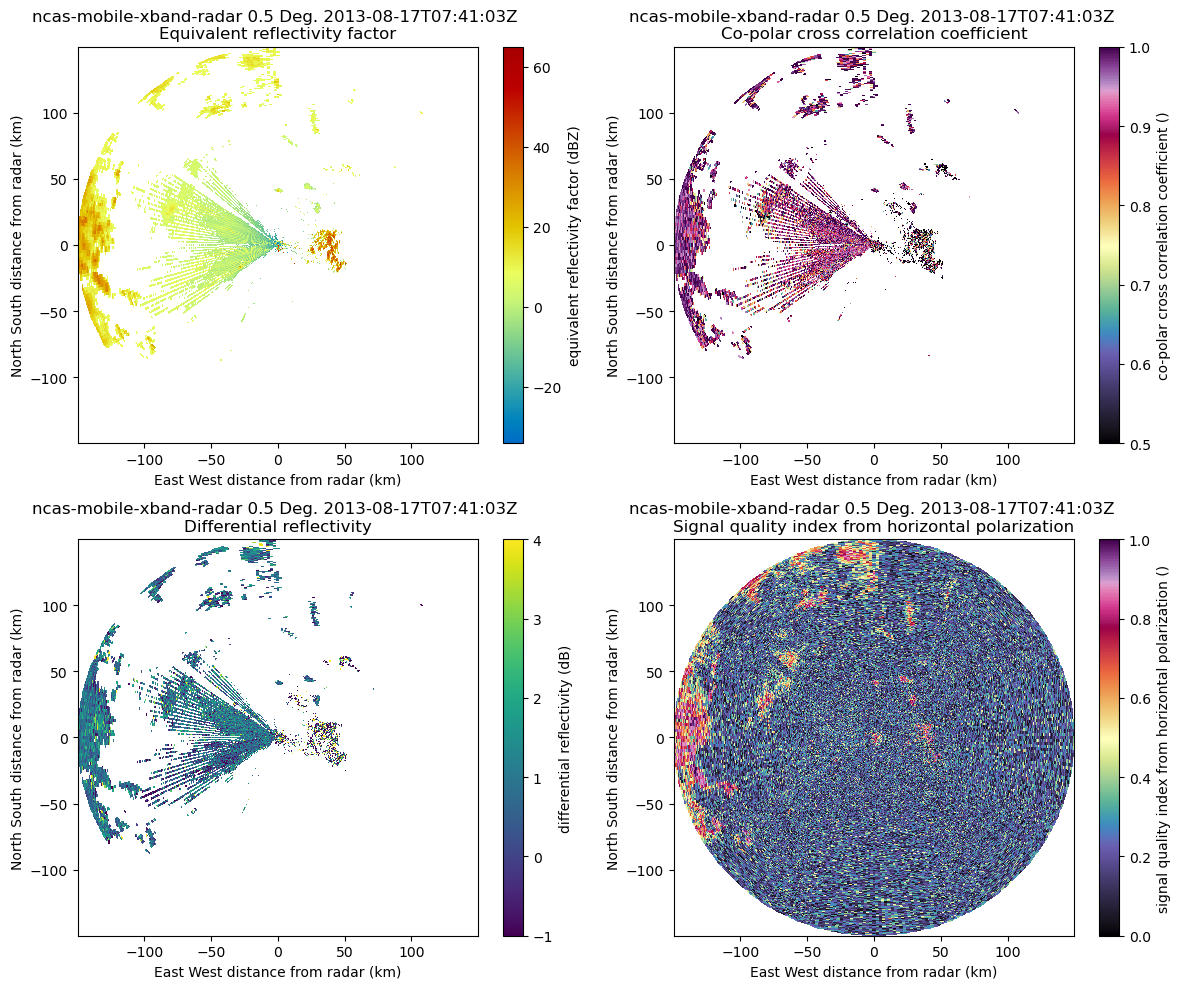

In [3]:
fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221)
raddisp.plot_ppi("dBuZ", 0,  
                 cmap=pycm.HomeyerRainbow,
                 ax=ax1)

ax2 = plt.subplot(222)
raddisp.plot_ppi("RhoHV", 0,
                 cmap=pycm.ChaseSpectral,
                 vmin=0.5,vmax=1,
                 ax=ax2)

ax3 = plt.subplot(223)
raddisp.plot_ppi("ZDR", 0, 
                     vmin=-1, vmax=4,  
                     ax=ax3)

ax4 = plt.subplot(224)
raddisp.plot_ppi("SQI", 0,
                 cmap=pycm.ChaseSpectral,
                     vmin=0, vmax=1,  
                     ax=ax4)
plt.tight_layout()

The sector to the west of the radar contains a significant region of second trip echoes close to the radar. These are noticable in this case due to a number of factors:

1. The sharp edges to the echoes close in to the radar are a good visual clue.
2. The presence of moderate reflectivity echoes right at the edge of the domain in the same direction.
3. The radial striping within the echoes (particularly noticeable in ZDR).
4. Low SQI within the sector to the west, the second trip echoes are not visible amongst the background signal.

Of these the simplest avenue to persue from a coding perspective is the use of SQI as an indicator. From the PPI plot there's an indication that SQI above approximately 0.4 could be considered to represent first trip echoes. We can introduce the ```pyart.filters.GateFilter``` object here as a convenient method of applying filtering without modifying the underlying data within the radar file/object.

#### PyART GateFilters

PyART GateFilters provide a class for generating boolean (True/False) masks for use within other PyART functions (mainly plotting, but also some processing). As a boolean they are not correcting the data, simply acting as a tool to remove gates which aren't useful for the task in hand. While simple GateFilters can be built using one or more threhsolds on individual radar variables some inbuilt functions provide more complex methods for building the boolean masks, while it is also possible to do this externally to PyART and then parse them into a GateFilter to improve usability.

First we will define a basic GateFilter and then use it to replot the fields above.



In [4]:
gatefilter1 = pyart.filters.GateFilter(radar) # Define a GateFilter object
gatefilter1.exclude_below('SQI',0.4) # Modify the object to now exclude all SQI data below 0.4

We can then pass the ```gatefilter1``` object into the "gatefilter" argument within the ```plot_ppi``` function

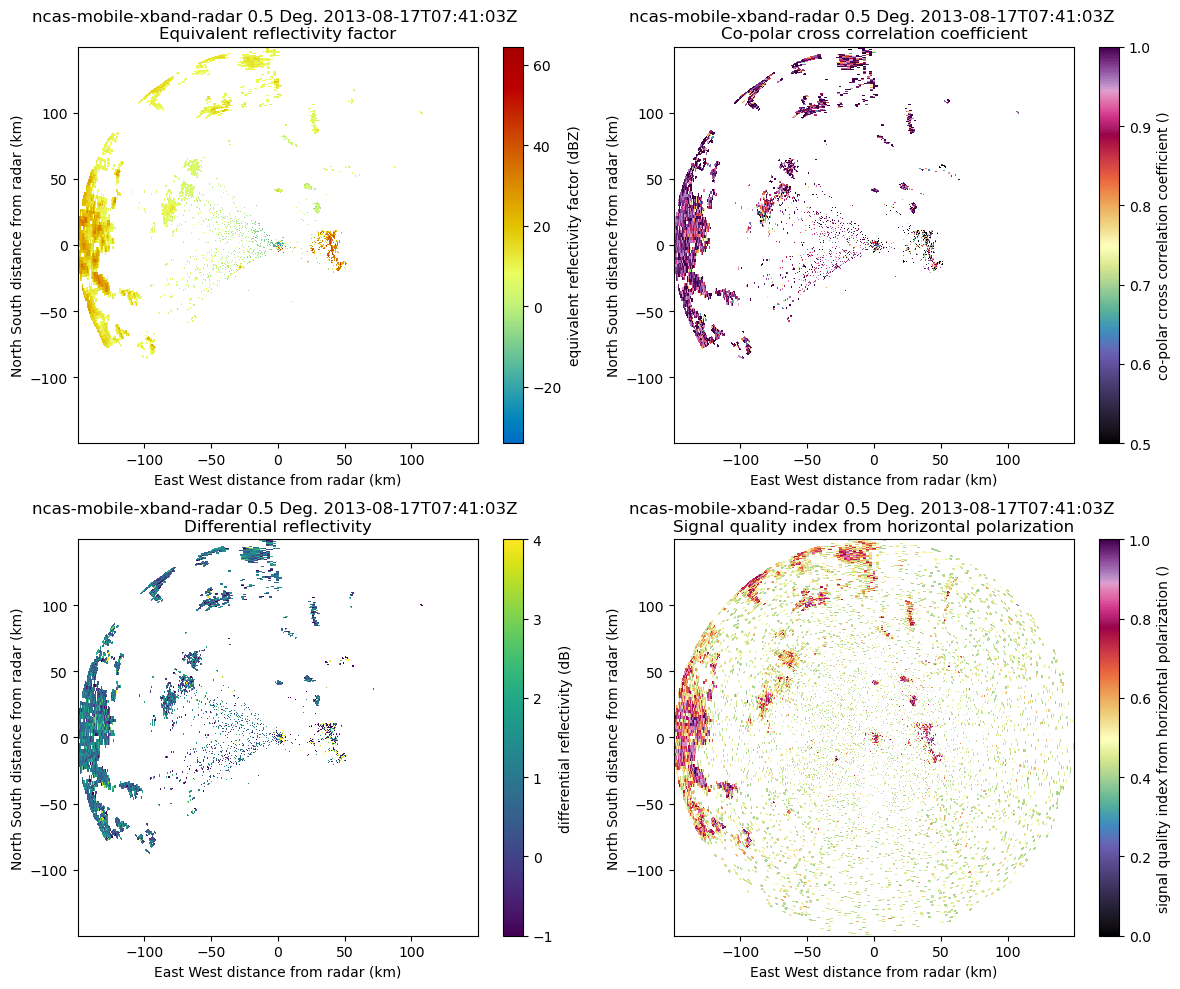

In [5]:
fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221)
raddisp.plot_ppi("dBuZ", 0,  
                 cmap=pycm.HomeyerRainbow,
                 gatefilter=gatefilter1,
                 ax=ax1)

ax2 = plt.subplot(222)
raddisp.plot_ppi("RhoHV", 0,
                 cmap=pycm.ChaseSpectral,
                 gatefilter=gatefilter1,
                 vmin=0.5,vmax=1,
                 ax=ax2)

ax3 = plt.subplot(223)
raddisp.plot_ppi("ZDR", 0, 
                     vmin=-1, vmax=4,
                 gatefilter=gatefilter1,  
                     ax=ax3)

ax4 = plt.subplot(224)
raddisp.plot_ppi("SQI", 0,
                 cmap=pycm.ChaseSpectral,
                 gatefilter=gatefilter1,
                     vmin=0, vmax=1,  
                     ax=ax4)
plt.tight_layout()

Here we notice that while the bulk of the second trip returns to the west of the radar have been removed there is still a visible region of spurious echoes. Feel free to adjust the threshold value used from 0.4 to see how that impacts the PPIs.

As these echoes are now quite patchy in appearance we can use another approach, despeckling, to clean up the data. This is simply a method of removing individual gates, or small clusters of them, which are not connected to a larger echo. Once again, PyART now has an inbuilt function for applying this technique, ```pyart.correct.despeckle_field```. We can interogate this method in the notebook to see how it works:

In [6]:
pyart.correct.despeckle_field?

We will apply the speckle filter to the 'dBuZ' reflectivity field, keeping the default values for the threshold (all echoes above -100dBZ are included) and the size (at least 10 connected gates). We'll recreate our original gatefilter to mask the dBuZ field prior to identifying connected regions (if we simply pass the original, gatefilter1, it will be modified by the despeckle function).

In [7]:
gatefilter2 = pyart.filters.GateFilter(radar) # Define a GateFilter object
gatefilter2.exclude_below('SQI',0.4) # Modify the object to now exclude all SQI data below 0.4
gatefilter2 = pyart.correct.despeckle_field(radar,'dBuZ',gatefilter=gatefilter2)

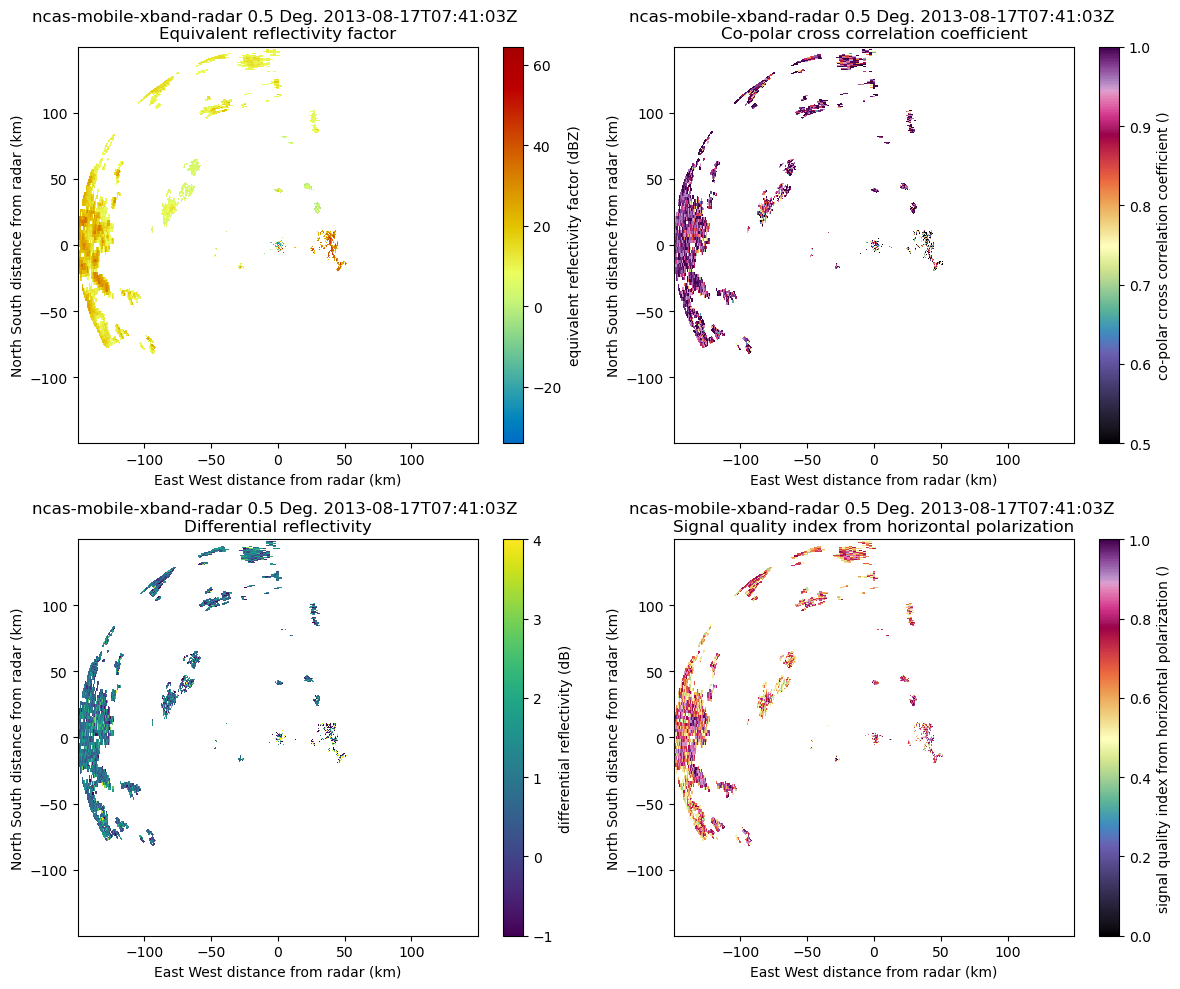

In [8]:
fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221)
raddisp.plot_ppi("dBuZ", 0,  
                 cmap=pycm.HomeyerRainbow,
                 gatefilter=gatefilter2,
                 ax=ax1)

ax2 = plt.subplot(222)
raddisp.plot_ppi("RhoHV", 0,
                 cmap=pycm.ChaseSpectral,
                 gatefilter=gatefilter2,
                 vmin=0.5,vmax=1,
                 ax=ax2)

ax3 = plt.subplot(223)
raddisp.plot_ppi("ZDR", 0, 
                     vmin=-1, vmax=4,
                 gatefilter=gatefilter2,  
                     ax=ax3)

ax4 = plt.subplot(224)
raddisp.plot_ppi("SQI", 0,
                 cmap=pycm.ChaseSpectral,
                 gatefilter=gatefilter2,
                     vmin=0, vmax=1,  
                     ax=ax4)
plt.tight_layout()

#### Extension code - spatial averaging before thresholding

While this is clearly an improvement we can introduce one final change to the filtering. By spatially averaging the SQI field we can increase the contrast between first and second trip echoes (Dufton, 2016). A moving window mean across the polar data can be coded in multiple ways, perhaps using loops and slices but in this case we'll apply a convolution using an averaging kernel. A convolution is basically a sliding multiplication of two functions, for a good explanation see this better explained article (https://betterexplained.com/articles/intuitive-convolution/) but here all we need to know is that it provides a computationally efficient way to generate a moving window mean.


In order to do so we will use the ```scipy.ndimage``` module to convolve the original data with an averaging kernel of the desired size (here we'll use 5x5, but you can explore other options if you like) to generate a mean field. This looks like this:

In [9]:
kernel_shape = np.ones((5,5)) # Equal weight for each point in the kernel, shape 5 x 5

# Convolution is the sum of the multiples, so dividing by the total number of points
# in the kernel will give the mean
average_kernel = kernel_shape/kernel_shape.sum()

# Run the averaging kernel over the data
SQI_mean = sciim.convolve(radar.fields['SQI']['data'], average_kernel)

However there is a flaw in this approach. The SQI array is non-continuous, as the array is actually 10 radar sweeps joined into a single array. To correctly calculate the mean we can chunk the array into its individual sweeps to do the calculation.

In [10]:
SQI_mean_sweeps = np.zeros((radar.nrays,radar.ngates)) # Create a placeholder for the results

# Create a loop for each sweep
for sweep_index in range(radar.nsweeps):
    sweep_mean_SQI = sciim.convolve(radar.fields['SQI']['data'][radar.get_slice(sweep_index)],
                                    np.ones((5,5)))/25.0
    SQI_mean_sweeps[radar.get_slice(sweep_index)] = sweep_mean_SQI

This currently ignores edge effects at the beginning and end of each elevation sweep, you might want to consider a different approach but the default here is to reflect the data at the edges of the arrays.

We'll go ahead and add the new data to the radar object as a field and then use it to create a new gatefilter, either similar to the last one or without despeckling.

In [11]:
radar.add_field_like('SQI','SQIm', SQI_mean_sweeps)

In [12]:
gatefilter3 = pyart.filters.GateFilter(radar)
gatefilter3.exclude_below('SQIm',0.4)
# Comment or uncomment the next line to exclude/include despeckling 
#gatefilter3 = pyart.correct.despeckle_field(radar,'dBuZ',gatefilter=gatefilter3) 

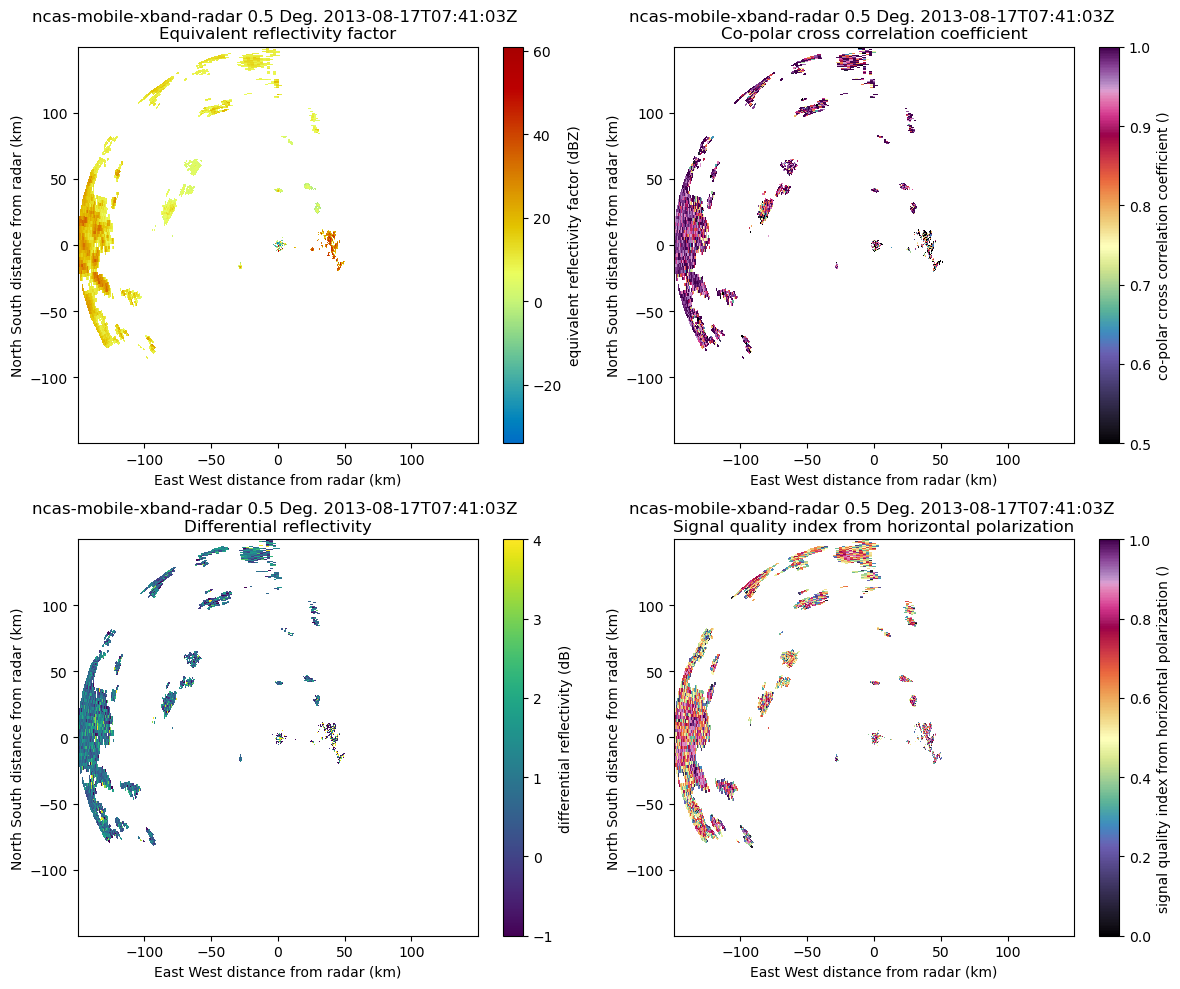

In [13]:
fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221)
raddisp.plot_ppi("dBuZ", 0,  
                 cmap=pycm.HomeyerRainbow,
                 gatefilter=gatefilter3,
                 ax=ax1)

ax2 = plt.subplot(222)
raddisp.plot_ppi("RhoHV", 0,
                 cmap=pycm.ChaseSpectral,
                 gatefilter=gatefilter3,
                 vmin=0.5,vmax=1,
                 ax=ax2)

ax3 = plt.subplot(223)
raddisp.plot_ppi("ZDR", 0, 
                     vmin=-1, vmax=4,
                 gatefilter=gatefilter3,  
                     ax=ax3)

ax4 = plt.subplot(224)
raddisp.plot_ppi("SQI", 0,
                 cmap=pycm.ChaseSpectral,
                 gatefilter=gatefilter3,
                     vmin=0, vmax=1,  
                     ax=ax4)
plt.tight_layout()

We'll finish by creating a plot comparing the original data to the same field filtered using each of the gatefilters.

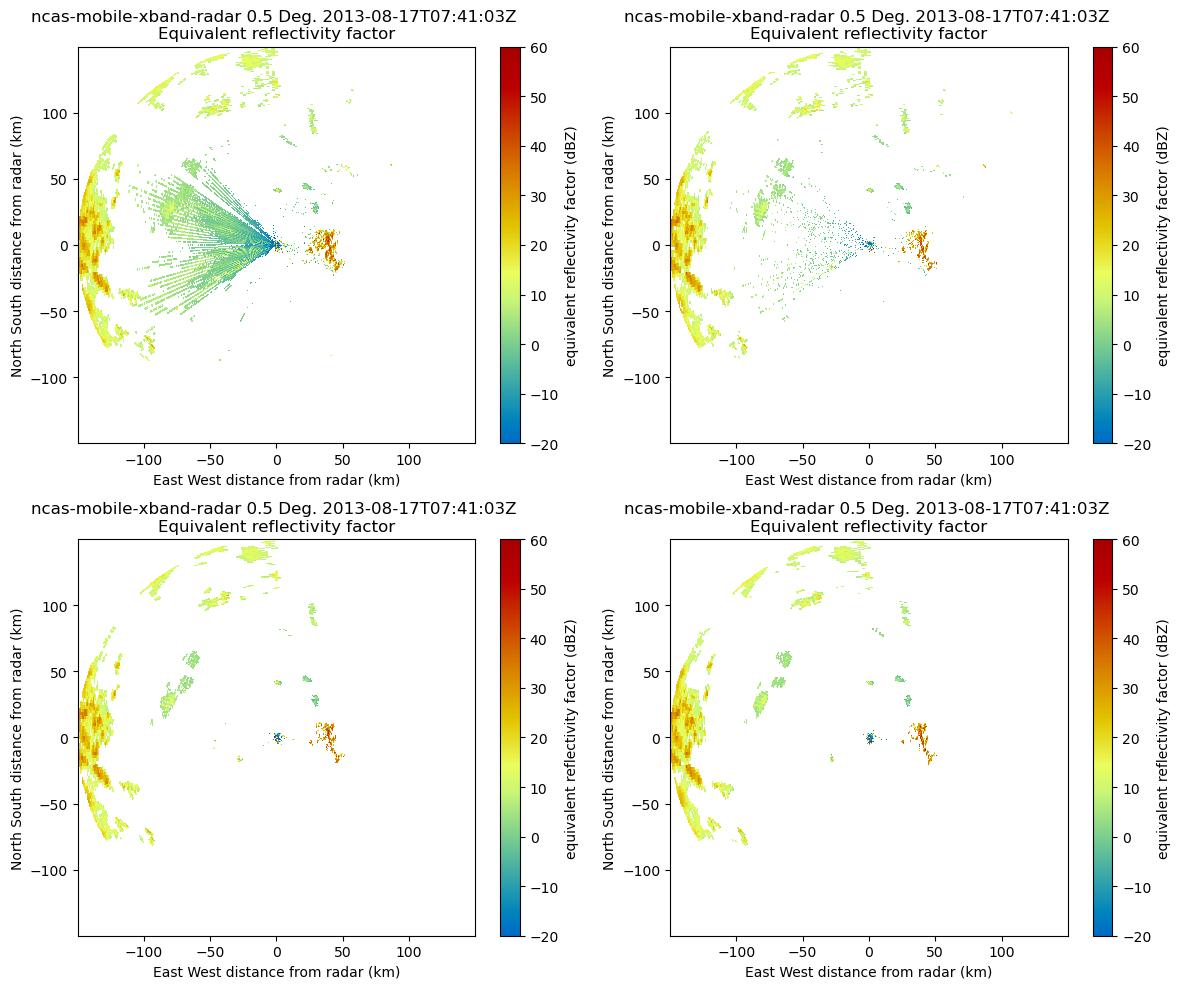

In [14]:
fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221)
raddisp.plot_ppi("dBuZ", 0,  
                     ax=ax1,
                 cmap=pycm.HomeyerRainbow,
                 vmin=-20,vmax=60,
                 )

ax2 = plt.subplot(222)
raddisp.plot_ppi("dBuZ", 0,  
                     ax=ax2,
                 cmap=pycm.HomeyerRainbow,
                 vmin=-20,vmax=60,
                 gatefilter=gatefilter1)

ax3 = plt.subplot(223)
raddisp.plot_ppi("dBuZ", 0,  
                     ax=ax3,
                 cmap=pycm.HomeyerRainbow,
                 vmin=-20,vmax=60,
                 gatefilter=gatefilter2)

ax4 = plt.subplot(224)
raddisp.plot_ppi("dBuZ", 0,  
                     ax=ax4,
                 cmap=pycm.HomeyerRainbow,
                 vmin=-20,vmax=60,
                 gatefilter=gatefilter3)
plt.tight_layout()

While the lower 2 plots may be sufficiently filtered that will depend on the final use case of the data. Additional steps could involve incorporating ray to ray variability information for the other variables, changing the PRF of the radar to extend the unambiguous range, including additional algorithms in the signal processor to remove second trip echoes before moment generation and/or including external data (another radar/satellite cloud data) to identify misplaced echoes.

This practical exercise has introduced ```GateFilters``` as a method of thresholding radar data. If you are using functions developed outside of PyART (or that do not explicitly allow for GateFilters) they can still be used as a helper for developing a Boolean mask / combination of masks but you will then need to manually apply the mask to your data before using it in your processing.

#### Next steps:

We'll continue to use ```GateFilters``` in the following practical exercise (practical 4, part 2) and then apply them to our case study data.